In [1]:
# ref https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from matplotlib import figure, pyplot
import math
import nltk
from nltk.corpus import stopwords

import pandas as pd
from scipy.sparse import coo_matrix

from operator import itemgetter
import heapq
import collections
from pathlib import Path



In [95]:
doclist = []
names = []
pathlist = Path("Data").glob('**/*.txt')
print(pathlist)
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    print(path_in_str)
    name = path_in_str.split("\\")[1].split(".")[0]
    names.append(name)
    #TODO SPLIT PATH TO COMPANY NAME, make Index
    file = open(path, "r") 
    # print "Output of Readlines after appending"
    text = file.readlines()
    doclist.append(text[0])


<generator object Path.glob at 0x000002637D0C2A98>
Data\1800FLOWERSCOMInc.txt
Data\2UInc.txt
Data\3DSystemsCorporation.txt


In [96]:
# doclist[1]
names

['1800FLOWERSCOMInc', '2UInc', '3DSystemsCorporation']

In [117]:
def split_document(doc_text):
    split_text = doc_text.split(".")
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,len(doc_text)))
#     vectorizer = TfidfVectorizer(stop_words='english')

    # TODO: Custom stopwords, 1-800-flowers returned in multiple slices/formats-> Replace with [name]?
    X = vectorizer.fit_transform(split_text)
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
    return X, vectorizer

In [118]:
doclist[0].split(".")

['[1] "Item 1A',
 ' Risk Factors',
 ' Cautionary Statements Under the Private Securities Litigation Reform Act of 1995',
 ' Our disclosures and analysis in this Form 10-K contain some forward-looking statements that set forth anticipated results based on management’s plans and assumptions',
 ' From time to time, we also provide forward-looking statements in other statements we release to the public as well as oral forward-looking statements',
 ' Such statements give our current expectations or forecasts of future events; they do not relate strictly to historical or current facts',
 ' We have tried, wherever possible, to identify such statements by using words such as “anticipate,” “estimate,” “expect,” “project,” “intend,” “plan,” “believe” and similar expressions in connection with any discussion of future operating or financial performance',
 ' In particular, these include statements relating to future actions; the effectiveness of our marketing programs; the performance of our exist

In [119]:
X = split_document(doclist[0])
X

(<337x26929 sparse matrix of type '<class 'numpy.float64'>'
 	with 29888 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 41112), norm='l2', preprocessor=None,
         smooth_idf=True, stop_words='english', strip_accents=None,
         sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, use_idf=True, vocabulary=None))

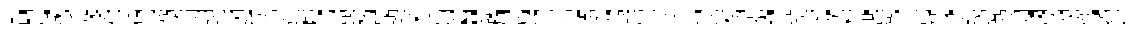

In [120]:
%matplotlib inline  

# https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = pyplot.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, facecolor ='black')
    ax.plot(m.col, m.row, 's', color='white', ms=3)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax



ax = plot_coo_matrix(X[0])
ax.figure.show()


In [121]:
# truek = PLEASE_FIND_ME
truek = 25
model = KMeans(n_clusters=truek, init='k-means++', max_iter=100, n_init=1)
model.fit(X[0])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=25, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [122]:

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = X[1].get_feature_names()


In [123]:
nclosest_words_to_show = 5
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :nclosest_words_to_show]:
     print(' %s' % terms[ind])

Cluster 0:
 diverts management attention resources
 management attention resources material adverse effect company
 diverts management attention resources material adverse effect company business results
 diverts management attention resources material adverse effect company business results operations
 management attention
Cluster 1:
 company
 25cf
 com
 customers
 flowers
Cluster 2:
 water supplies result material losses crops lead shortage product supply
 substantial reduction water supplies result material losses
 result material losses crops lead shortage
 result material losses crops lead shortage product
 result material losses crops lead shortage product supply
Cluster 3:
 maintain company service company
 telecommunications providers adequately maintain company service company experience failures
 providers adequately maintain company service company experience
 providers adequately maintain company service company experience failures
 providers adequately maintain company ser

In [124]:
print('\n')
print('Prediction')
vectorizer = X[1]
X = vectorizer.transform(['Market outlook on coffee looks promising'])
predicted = model.predict(X)
print(predicted)




Prediction
[1]


In [125]:
# HOW DO WE FIND OUT WHAT #7 meams?, 1Closest_word to cluster definitely isn't it
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :1]:
     print(' %s' % terms[ind])

Cluster 0:
 diverts management attention resources
Cluster 1:
 company
Cluster 2:
 water supplies result material losses crops lead shortage product supply
Cluster 3:
 maintain company service company
Cluster 4:
 conditions
Cluster 5:
 economic conditions deteriorate company customers disposable income consumers
Cluster 6:
 card
Cluster 7:
 product liability claims
Cluster 8:
 use
Cluster 9:
 item 1a
Cluster 10:
 investors permitted private securities litigation reform act 1995
Cluster 11:
 contents
Cluster 12:
 limit growth company
Cluster 13:
 experience
Cluster 14:
 company required incur substantial costs issue refunds credits replacement products
Cluster 15:
 brands expand
Cluster 16:
 domains issued
Cluster 17:
 customers 100 satisfaction guarantee products
Cluster 18:
 periods meet company expectations generate
Cluster 19:
 operations significantly fluctuate combination factors outside management control
Cluster 20:
 operating results
Cluster 21:
 cause economic slowdown united 

In [126]:
# using joblib to pickle model
from sklearn.externals import joblib
joblib.dump(model,  'doc_cluster.pkl')
model = joblib.load('doc_cluster.pkl')

In [144]:
## TF-IDF analysis 
from nltk.corpus import stopwords
def get_wordset(doc_text):
    words = doc_text.split(" ")
    wordSet = []
    stopWordsSet =  set(stopwords.words('english'))

    print(stopWords)
    for w in words:
    #     wordSet.append(w)

        if w not in stopWords:
            wordSet.append(w)
    return wordSet

In [145]:
def get_wordDict(wordSet):
    wordDict = dict.fromkeys(wordSet, 0) 
    for word in wordSet:
        wordDict[word]+=1

    return wordDict

In [146]:


def computeTF(document_text):
    wordset = get_wordset(document_text)
    word_dict = get_wordDict(wordset)
    tfDict = {}
    word_count = len(wordset)
    for word, count in word_dict.items():
        tfDict[word] = count/float(word_count)
    return tfDict

In [147]:
doclist[0]

'[1] "Item 1A. Risk Factors. Cautionary Statements Under the Private Securities Litigation Reform Act of 1995. Our disclosures and analysis in this Form 10-K contain some forward-looking statements that set forth anticipated results based on management’s plans and assumptions. From time to time, we also provide forward-looking statements in other statements we release to the public as well as oral forward-looking statements. Such statements give our current expectations or forecasts of future events; they do not relate strictly to historical or current facts. We have tried, wherever possible, to identify such statements by using words such as “anticipate,” “estimate,” “expect,” “project,” “intend,” “plan,” “believe” and similar expressions in connection with any discussion of future operating or financial performance. In particular, these include statements relating to future actions; the effectiveness of our marketing programs; the performance of our existing products and services; ou

In [148]:
term_frequency = computeTF(doclist[0])

{'his', 'both', 'some', 'she', 'have', 'theirs', 'i', 'needn', 'further', 'if', 'each', 'too', 'in', 'has', 'through', 're', "wasn't", 'are', 'shan', 'herself', 'had', 'can', 'yourself', 'been', 'll', 'shouldn', 'few', 'about', 'her', 'couldn', 'be', 'and', 'wouldn', 'other', 'by', "shan't", "mustn't", 'up', 'hasn', 't', 'ain', 'any', 'weren', 'there', 'as', "won't", "couldn't", "isn't", 'a', 'at', "hadn't", 'd', 'so', 'my', 'won', 'did', 'under', "mightn't", 'haven', 'for', 'o', 'myself', "needn't", 'where', 'ma', "you've", 'with', "aren't", 'nor', "weren't", 'against', "wouldn't", 'until', 'while', 'does', 'between', 'all', 'above', 'itself', "you'd", 'into', 'm', 'didn', 'were', 'then', 'own', 'just', 'on', "didn't", 'me', 'what', 'over', 'do', 'whom', "it's", 'don', 'yourselves', 'wasn', 'will', 'more', 'only', 'but', "that'll", 'who', "don't", 'we', 'when', 'the', 'you', 'them', 'hadn', 'or', 'again', 'these', 'ours', 'him', 'himself', 'having', 'those', 'most', 'is', 'was', 'once

In [149]:
term_frequency

{'[1]': 0.0002536783358701167,
 '"Item': 0.0002536783358701167,
 '1A.': 0.0002536783358701167,
 'Risk': 0.0002536783358701167,
 'Factors.': 0.0002536783358701167,
 'Cautionary': 0.0002536783358701167,
 'Statements': 0.0002536783358701167,
 'Under': 0.0005073566717402334,
 'Private': 0.0005073566717402334,
 'Securities': 0.0010147133434804667,
 'Litigation': 0.00076103500761035,
 'Reform': 0.0005073566717402334,
 'Act': 0.00076103500761035,
 '1995.': 0.0002536783358701167,
 'Our': 0.0012683916793505834,
 'disclosures': 0.0005073566717402334,
 'analysis': 0.0002536783358701167,
 'Form': 0.0015220700152207,
 '10-K': 0.0005073566717402334,
 'contain': 0.00076103500761035,
 'forward-looking': 0.0012683916793505834,
 'statements': 0.0015220700152207,
 'set': 0.0002536783358701167,
 'forth': 0.0002536783358701167,
 'anticipated': 0.0002536783358701167,
 'results': 0.00837138508371385,
 'based': 0.0002536783358701167,
 'management’s': 0.0005073566717402334,
 'plans': 0.0005073566717402334,
 'a

In [150]:
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    big_wordset = []
    for doc in docList:
        big_wordset += get_wordset(doc)
    big_wordDict = get_wordDict(big_wordset)
        
    idfDict = dict.fromkeys(big_wordDict.keys(), 0)
  
    for word, val in big_wordDict.items():
        if val > 0:
            idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [135]:
idfs = computeIDF(doclist)
idfs

AttributeError: 'list' object has no attribute 'words'

In [84]:
def computeTFIDF(term_frequency, idfs):
    tfidf = {}
    for word, val in term_frequency.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [85]:
tfidfBow = computeTFIDF(term_frequency, idfs)


In [86]:
tfidfBow


{'[1]': 0.00012103532590554602,
 '"Item': 0.00012103532590554602,
 '1A.': 0.00012103532590554602,
 'Risk': 0.00012103532590554602,
 'Factors.': 0.00012103532590554602,
 'Cautionary': 0.00012103532590554602,
 'Statements': 0.00012103532590554602,
 'Under': 0.00024207065181109204,
 'Private': 0.00024207065181109204,
 'Securities': 0.0004841413036221841,
 'Litigation': 0.0003631059777166381,
 'Reform': 0.00024207065181109204,
 'Act': 0.0003631059777166381,
 '1995.': 0.00012103532590554602,
 'Our': 0.0006051766295277301,
 'disclosures': 0.00024207065181109204,
 'analysis': 0.00012103532590554602,
 'Form': 0.0007262119554332762,
 '10-K': 0.00024207065181109204,
 'contain': 0.0003631059777166381,
 'forward-looking': 0.0006051766295277301,
 'statements': 0.0007262119554332762,
 'set': 0.00012103532590554602,
 'forth': 0.00012103532590554602,
 'anticipated': 0.00012103532590554602,
 'results': 0.003994165754883019,
 'based': 0.00012103532590554602,
 'management’s': 0.00024207065181109204,
 'pl

In [14]:
# from https://stackoverflow.com/questions/4743035/obtaining-the-least-common-element-in-array
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))
least_common_values(tfidfBow, 5)

NameError: name 'tfidfBow' is not defined

In [15]:
collections.Counter(tfidfBow).most_common(20)


NameError: name 'tfidfBow' is not defined

In [89]:
collections.Counter(term_frequency).most_common(20)



[('may', 0.030187721968543885),
 ('Company’s', 0.02207001522070015),
 ('Company', 0.021816336884830034),
 ('The', 0.014205986808726534),
 ('could', 0.013952308472856417),
 ('customers', 0.0091324200913242),
 ('results', 0.00837138508371385),
 ('If', 0.007864028411973617),
 ('<U+25CF>', 0.006595636732623034),
 ('\\t\\t\\t', 0.006595636732623034),
 ('products', 0.006341958396752917),
 ('customer', 0.0060882800608828),
 ('significant', 0.004819888381532217),
 ('In', 0.0045662100456621),
 ('ability', 0.0045662100456621),
 ('use', 0.0045662100456621),
 ('operating', 0.004058853373921867),
 ('result', 0.004058853373921867),
 ('number', 0.004058853373921867),
 ('affect', 0.004058853373921867)]

In [17]:
# Latent Dirichlet Allocation
# Ref http://brandonrose.org/clustering
# LDA is a probabilistic topic model that assumes documents
# are a mixture of topics and that each word in the document is attributable to the document's topics.
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

input_texts = doclist

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
from gensim import corpora, models, similarities 

#remove proper names0
%time preprocess = [strip_proppers(doc) for doc in input_texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
# print(texts)
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)
# print(dictionary)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
# dictionary.filter_extremes(no_below=1, no_above=0.8)  THIS FILTERS EVERYTHING OUT
# print(dictionary)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
# print(corpus)
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 556 ms
Wall time: 921 ms
Wall time: 94.7 ms
Wall time: 3.58 s


In [18]:
lda.show_topics()


[(0,
  '0.028*"may" + 0.018*"\\t\\t\\t" + 0.017*"could" + 0.016*"product" + 0.014*"busi" + 0.013*"result" + 0.013*"custom" + 0.013*"oper" + 0.007*"\\t\\t" + 0.007*"advers"'),
 (1,
  '0.001*"may" + 0.001*"economi" + 0.001*"search" + 0.001*"scenario" + 0.001*"sabotag" + 0.001*"updat" + 0.001*"result" + 0.001*"along" + 0.001*"relev" + 0.001*"enough"'),
 (2,
  '0.021*"may" + 0.021*"univers" + 0.020*"could" + 0.018*"client" + 0.015*"student" + 0.012*"offer" + 0.011*"program" + 0.010*"oper" + 0.009*"us" + 0.009*"result"'),
 (3,
  '0.001*"may" + 0.001*"could" + 0.001*"univers" + 0.001*"program" + 0.001*"abil" + 0.001*"offer" + 0.001*"client" + 0.001*"result" + 0.001*"busi" + 0.001*"oper"'),
 (4,
  '0.001*"may" + 0.001*"could" + 0.001*"busi" + 0.001*"oper" + 0.001*"univers" + 0.001*"willing" + 0.001*"forth" + 0.001*"notifi" + 0.001*"efforts.." + 0.001*"worker"')]

In [19]:
topics_matrix = lda.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['may', '\\t\\t\\t', 'could', 'product', 'busi', 'result', 'custom', 'oper', '\\t\\t', 'advers', 'financi', 'signific', 'use', 'materi', 'inform']

['may', 'set', 'worker', 'enough', 'relev', 'willing', 'efforts..', 'along', 'economi', 'result', 'updat', 'sabotag', 'scenario', 'search', 'could']

['may', 'univers', 'could', 'client', 'student', 'offer', 'program', 'oper', 'us', 'result', 'ani', 'abil', 'busi', 'new', 'addit']

['may', 'could', 'univers', 'program', 'offer', 'abil', 'client', 'result', 'oper', 'busi', 'ani', 'new', 'us', 'requir', 'cours']

['may', 'could', 'oper', 'busi', 'univers', 'notifi', 'worker', 'within', 'willing', 'efforts..', 'forth', 'forward', 'written', 'way', 'valuabl']



In [20]:
# https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing
lsi = models.lsimodel.LsiModel(corpus, num_topics=5, id2word=dictionary, chunksize=1000)
topics_matrix = lsi.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)
topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['may', 'could', 'univers', 'client', 'student', 'oper', 'result', 'busi', 'offer', 'program', 'us', 'ani', 'abil', 'new', 'addit']

['\\t\\t\\t', 'product', 'univers', 'client', 'student', 'custom', 'may', '\\t\\t', 'offer', 'program', 'busi', 'result', 'risk', 'oper', 'platform']

['custom', '\\t\\t\\t', 'may', '\\t\\t', 'risk', 'brand', 'number', 'us', 'result', 'card', 'parti', 'websit', 'technolog', 'system', 'relationship']

